In [19]:
'''
Adam Forestier
Last Updated: May 4, 2023
'''

# Imports
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns 

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay,RocCurveDisplay, roc_curve, auc)
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv


### Initial Data Investigation and Tuning

In [20]:
df = pd.read_csv('/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [21]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [22]:
# Can see there are no null values. Let's ensure there are no duplicates
df = df.drop_duplicates()

In [23]:
# Every age has .0 in decimal place. Let's convert to an integer as there is no month or day data; only age in years 
df['age'] = np.vectorize(lambda age: int(age))(df['age'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  int64  
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 7.3+ MB


In [24]:
# general data statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,96146.0,41.783756,22.482208,0.00,24.0,43.00,59.00,80.00
hypertension,96146.0,0.077601,0.267544,0.00,0.0,0.00,0.00,1.00
heart_disease,96146.0,0.040803,0.197833,0.00,0.0,0.00,0.00,1.00
bmi,96146.0,27.321461,6.767716,10.01,23.4,27.32,29.86,95.69
HbA1c_level,96146.0,5.532609,1.073232,3.50,4.8,5.80,6.20,9.00
blood_glucose_level,96146.0,138.218231,40.909771,80.00,100.0,140.00,159.00,300.00
diabetes,96146.0,0.088220,0.283616,0.00,0.0,0.00,0.00,1.00


In [25]:
# I see that both gender and smoking_history are string objects. 
# The model will perform better with both features are binary objects
# I keep the original data frame for more readable visualizations
final_df = pd.get_dummies(df, drop_first=True) 
final_df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80,0,1,25.19,6.6,140,0,0,0,0,0,0,1,0
1,54,0,0,27.32,6.6,80,0,0,0,0,0,0,0,0
2,28,0,0,27.32,5.7,158,0,1,0,0,0,0,1,0
3,36,0,0,23.45,5.0,155,0,0,0,1,0,0,0,0
4,76,1,1,20.14,4.8,155,0,1,0,1,0,0,0,0


In [26]:
# Let's investigate the correlation of each feature to the label we are trying to predict: diabetes
diabetes_correlation = final_df.corr()['diabetes'].sort_values()[:-1]
diabetes_correlation

gender_Other                  -0.004256
smoking_history_current        0.017037
smoking_history_not current    0.018921
smoking_history_ever           0.021915
smoking_history_never          0.023136
gender_Male                    0.037883
smoking_history_former         0.095492
heart_disease                  0.170711
hypertension                   0.195710
bmi                            0.214932
age                            0.264846
HbA1c_level                    0.406408
blood_glucose_level            0.424336
Name: diabetes, dtype: float64

**It appears blood_glucose_level and HbA1c_level are the two highest correlated features to diabetes**

### Data Exploration through Visualization

Text(0.5, 1.0, 'Diabetic vs Non-Diabetic by HbA1c and Blood Glucose')

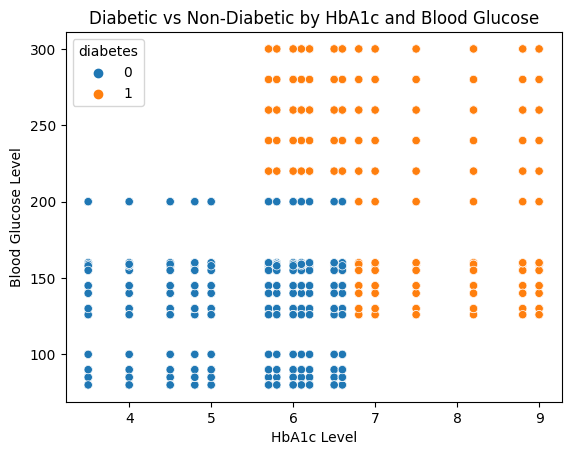

In [27]:
# View Relationship between two strongest correlated feature and the label
sns.scatterplot(x='HbA1c_level', y='blood_glucose_level', data=final_df, hue='diabetes')
plt.xlabel('HbA1c Level')
plt.ylabel('Blood Glucose Level')
plt.title('Diabetic vs Non-Diabetic by HbA1c and Blood Glucose')

**We can see a very clear seperation between diabetics and non-diabetics based on HbA1c level and blood glucose level.**

**This indicates to me, that a simple KNN model, or may be a good algorithms for this classification task. Lets Explore this relationship further.**

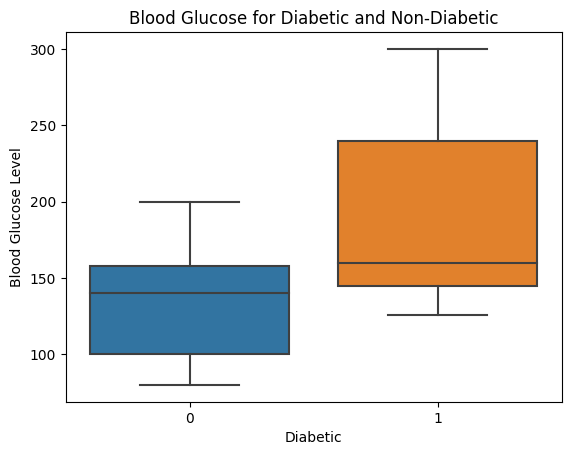

In [28]:
# Boxplot of blood glucose and diabetes
sns.boxplot(x='diabetes', y='blood_glucose_level', data=final_df)
plt.xlabel('Diabetic')
plt.ylabel('Blood Glucose Level')
plt.title('Blood Glucose for Diabetic and Non-Diabetic')
plt.show()

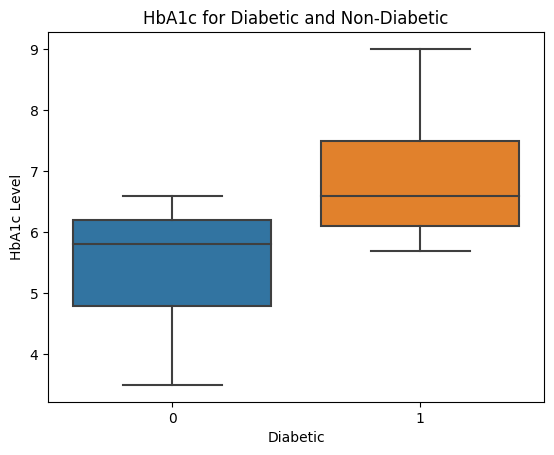

In [29]:
# Boxplot of blood glucose and diabetes
sns.boxplot(x='diabetes', y='HbA1c_level', data=final_df)
plt.xlabel('Diabetic')
plt.ylabel('HbA1c Level')
plt.title('HbA1c for Diabetic and Non-Diabetic')
plt.show()

**high blood glucose and HbA1C_level are strong indicators of diabetes**

**This indicates to me, that a simple KNN model, or may be a good algorithms for this classification task. Lets Explore this relationship further.**

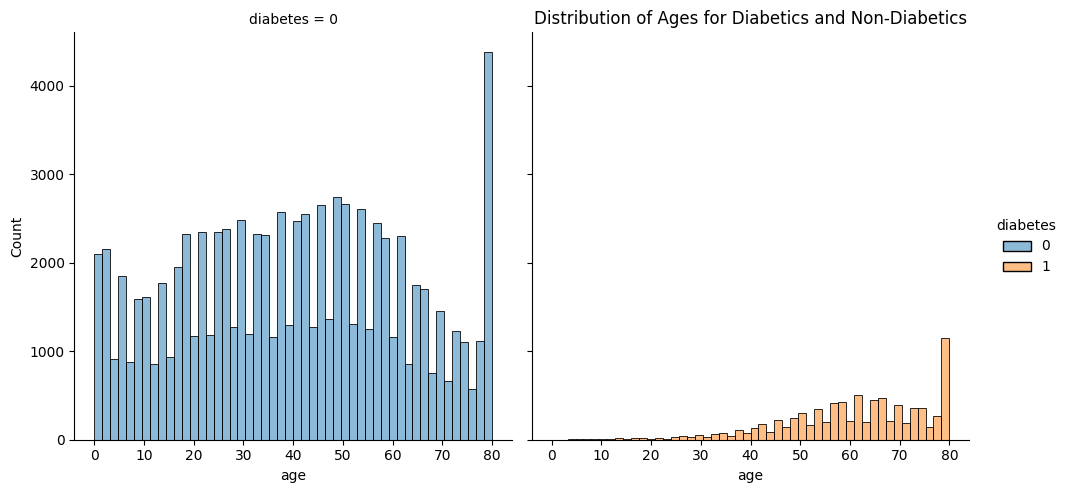

In [30]:
# Distribution of ages for those with and without diabetes
sns.displot(data=final_df, x='age', bins=50, col='diabetes', hue='diabetes')
plt.title('Distribution of Ages for Diabetics and Non-Diabetics')
plt.show()

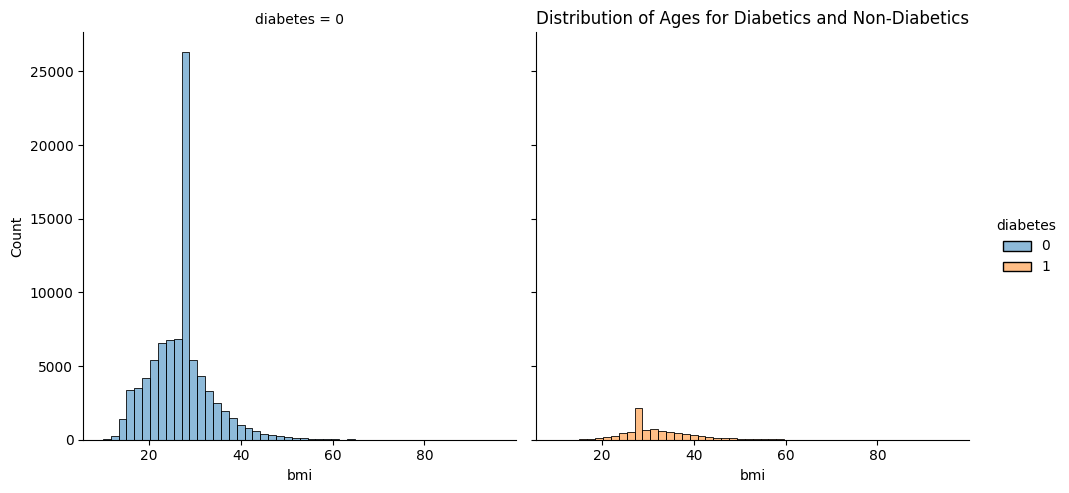

In [31]:
# Distribution of BMI for those with and without diabetes
sns.displot(data=final_df, x='bmi', bins=50, col='diabetes', hue='diabetes')
plt.title('Distribution of Ages for Diabetics and Non-Diabetics')
plt.show()

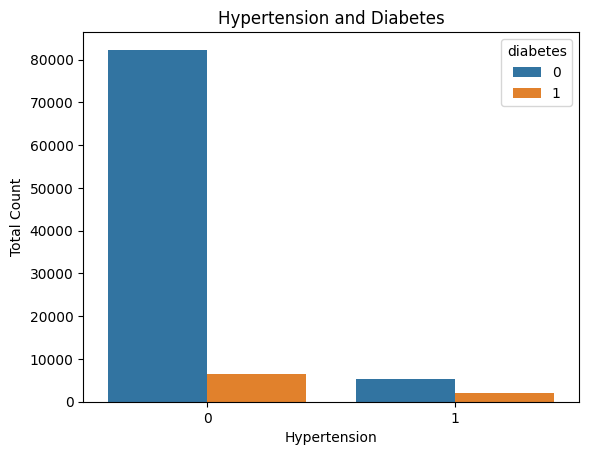

In [32]:
# View count of diabetics and non-diabetics by hypertension 
sns.countplot(data=final_df, x='hypertension', hue='diabetes')
plt.xlabel('Hypertension')
plt.ylabel('Total Count')
plt.title('Hypertension and Diabetes')
plt.show()

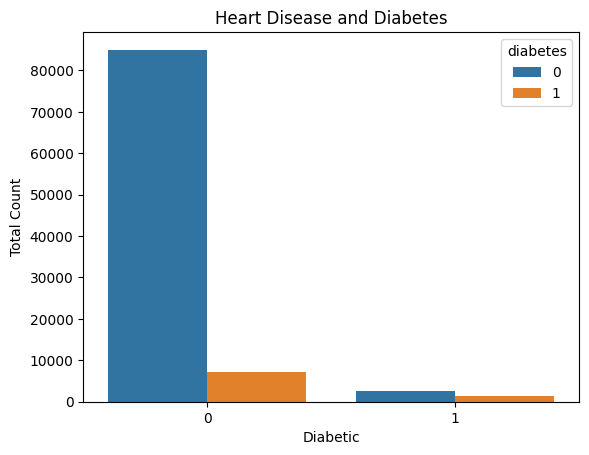

In [33]:
# View count of diabetics and non-diabetics by heart disease 
sns.countplot(data=final_df, x='heart_disease', hue='diabetes')
plt.xlabel('Diabetic')
plt.ylabel('Total Count')
plt.title('Heart Disease and Diabetes')
plt.show()

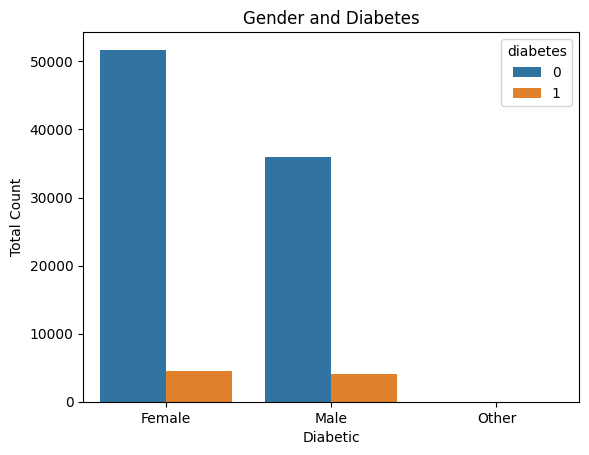

In [34]:
# Count of diabetics and non diabetics by gender
sns.countplot(data=df, x='gender', hue='diabetes')
plt.xlabel('Diabetic')
plt.ylabel('Total Count')
plt.title('Gender and Diabetes')
plt.show()

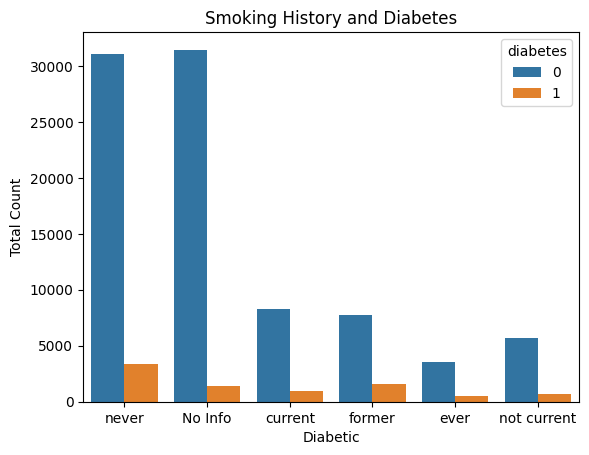

In [35]:
# Count of diabetics and non diabetics by gender
sns.countplot(data=df, x='smoking_history', hue='diabetes')
plt.xlabel('Diabetic')
plt.ylabel('Total Count')
plt.title('Smoking History and Diabetes')
plt.show()

**Count for those with heart disease and hypertension with no diabetes exceeds those with both and heart disease...**
**HOWEVER - we must remember the unbalanced dataset. They are near equal AND there are only 1/10 the amount of those with diabetes in the dataset.**

### Classification Models

**With all of the following visualized. Let's start training some models with the findings we have gathered**

**We are going to start with high bias and low variance (low complexity) and increase complexity**
**..The first model will be a very simple K Nearest Neighbors model utilizing only Blood Glucose and HbA1c**

In [36]:
# Seperate features and label. 
X = final_df[['blood_glucose_level', 'HbA1c_level']]
y = final_df['diabetes']

In [37]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=101)

In [38]:
# Scale data. Only fit training data to prevent data leakage
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [39]:
# Create a K Nearest Neighbors model with search for optimum amount of neighbors between 1 - 10. Use Minkowski algorithm for distance calculation
# We are trying to accurately predict when someone has diabetes. Use recall as the scoring metric
param_grid = {
    'n_neighbors': list(range(1, 11)),
    'metric':['minkowski'],
}
knn_clf = KNeighborsClassifier()
knn_clf = GridSearchCV(knn_clf, param_grid=param_grid, cv=5, scoring='recall')
knn_clf.fit(scaled_X_train, y_train)
y_pred = knn_clf.predict(scaled_X_test)
knn_params = knn_clf.best_estimator_.get_params()
knn_params

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [40]:
# Now that we have the best n_neighbors parameter. Create a model with those parameters
knn_clf = KNeighborsClassifier(n_neighbors=6, metric='minkowski')
knn_clf.fit(scaled_X_train, y_train)
y_pred = knn_clf.predict(scaled_X_test)

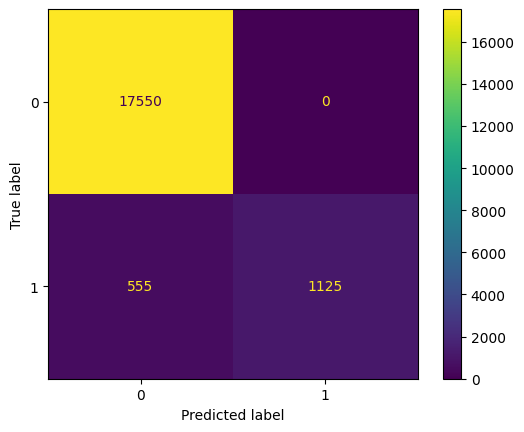

In [41]:
# Confusion matrix to display precision and recall. 
knn_cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
p = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=knn_clf.classes_)
p.plot()
plt.show()


In [42]:
# Classification Report
knn_cr = classification_report(y_true=y_test, y_pred=y_pred)
print(knn_cr)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17550
           1       1.00      0.67      0.80      1680

    accuracy                           0.97     19230
   macro avg       0.98      0.83      0.89     19230
weighted avg       0.97      0.97      0.97     19230



**This classifier performs very well in most facets. High precision and recall for non-diabetics. Overall accuracy of 97%**

**The classifier also always 100% correct when assigning the diabetic label to a patient. However it is missing 1/3 of the positive cases**

**There are too many false negatives. Considering the task of this model, to identify when individuals have diabetes. We need to have higher recall for class 1, even if it is at the expense of other scores**

**Let us see if more complex models can perform recall better**

In [43]:
# Let's try another distance based classifier. Support Vector Classifier using the 5 strongest correlated features
strongest_correlated_features = ['heart_disease', 'hypertension', 'bmi', 'age', 'HbA1c_level', 'blood_glucose_level']
X = final_df[strongest_correlated_features]
y = final_df['diabetes']

In [44]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=101)

In [45]:
# Scale data. Only fit training data to prevent data leakage
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [46]:
# Create a Support Vector Machine Classifier with cross validation
c = [.5, .75, .95, .99, 1]
degree = [1, 2, 3, 4]
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': c,
    'gamma': ['scale', 'auto'],
    'degree': degree,
}
svm_clf = SVC()
svm_clf = GridSearchCV(svm_clf, param_grid=param_grid, cv=2, scoring='recall')
svm_clf.fit(scaled_X_train, y_train)
y_pred = svm_clf.predict(scaled_X_test)
svm_params = svm_clf.best_estimator_.get_params()
svm_params

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

**Now that we have found the optimal parameters. Create two models model with those parameters: 1 with class weight=None and 2 with class weight='balanced'** 

**NOTE: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))**

**I hypothesize that balancing the class weight will result in better results; aka less False Negatives, as this is an unbalanced data set: 10x more people are non-diabetic as opposed to diabetic**

In [47]:
# With no balancing
svm_clf = SVC(class_weight=None, degree=3, gamma='scale', C=1, kernel='poly')
svm_clf.fit(scaled_X_train, y_train)
y_pred = svm_clf.predict(scaled_X_test)

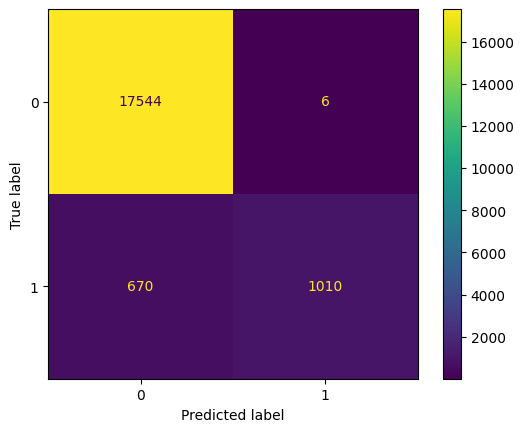

In [48]:
# Confusion matrix to display precision and recall. Calculate accuracy as well
svm_clf_cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
p = ConfusionMatrixDisplay(confusion_matrix=svm_clf_cm, display_labels=svm_clf.classes_)
p.plot()
plt.show()
svm_clf_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

In [49]:
# Classification Report
svm_clf_cr = classification_report(y_true=y_test, y_pred=y_pred)
print(svm_clf_cr)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17550
           1       0.99      0.60      0.75      1680

    accuracy                           0.96     19230
   macro avg       0.98      0.80      0.87     19230
weighted avg       0.97      0.96      0.96     19230



In [50]:
# With balancing
svm_balanced_clf = SVC(class_weight='balanced', degree=3, gamma='scale', C=1, kernel='poly')
svm_balanced_clf.fit(scaled_X_train, y_train)
y_pred = svm_clf.predict(scaled_X_test)

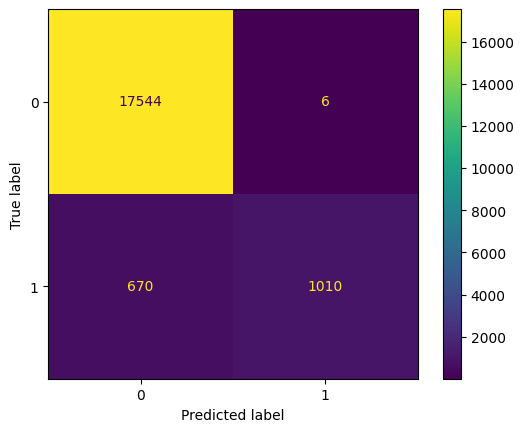

In [51]:
# Confusion matrix to display precision and recall.
svm_balanced_clf_cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
p = ConfusionMatrixDisplay(confusion_matrix=svm_balanced_clf_cm, display_labels=svm_balanced_clf.classes_)
p.plot()
plt.show()


In [52]:
# Classification Report
svm_balanced_clf_cr = classification_report(y_true=y_test, y_pred=y_pred)
print(svm_balanced_clf_cr)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17550
           1       0.99      0.60      0.75      1680

    accuracy                           0.96     19230
   macro avg       0.98      0.80      0.87     19230
weighted avg       0.97      0.96      0.96     19230



**Slightly disappointing Results from the Support Vector Machine Classifiers. The accuracy is still high, but the all important Recall for class 1 is even lower than the simplistic KNN model! Let's try some Ensemble approaches**

**We are going to train RandomForest, AdaBoost, and GradientBoost classifiers. For these models, we will use every feature to try to predict our label**

In [53]:
# Seperate features and label
X = final_df.drop('diabetes', axis=1)
y = final_df['diabetes']

In [54]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=101)

**NOTE: We do not need to scale for tree based models**

In [55]:
# Cross validated random forest
forest_clf = RandomForestClassifier(random_state=101, oob_score=True)
param_grid = {
    'n_estimators': [64, 100, 128, 200],
    'max_features': [2, 3, 4, 'sqrt'],
    'max_depth': [2, 3, 4],
    'criterion': ['entropy', 'gini']
}
grid_clf = GridSearchCV(estimator=forest_clf, param_grid=param_grid)
grid_clf.fit(X=X_train, y=y_train)
best_params = grid_clf.best_params_
best_params

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'n_estimators': 64}

**Now that we have found the optimal parameters, create 2 models using those params. One with balanced weight, and one without balanced weight**

In [56]:
# balanced
forest_clf = RandomForestClassifier(class_weight=None, n_estimators=64, max_features=4, max_depth=3, bootstrap=True, criterion='entropy', random_state=101)
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)

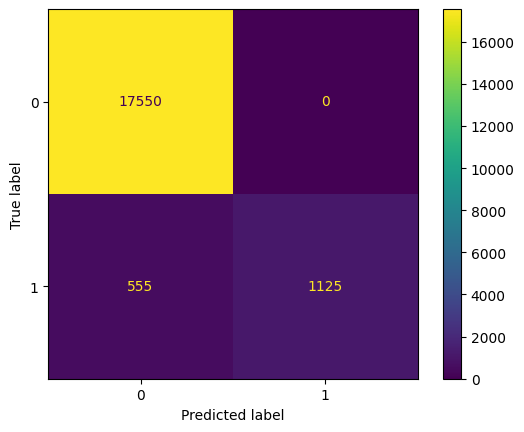

In [57]:
# Confusion matrix to display precision and recall.
forest_clf_cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
p = ConfusionMatrixDisplay(confusion_matrix=forest_clf_cm, display_labels=forest_clf.classes_)
p.plot()
plt.show()

In [58]:
# Classification Report
forest_clf_cr = classification_report(y_true=y_test, y_pred=y_pred)
print(forest_clf_cr)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17550
           1       1.00      0.67      0.80      1680

    accuracy                           0.97     19230
   macro avg       0.98      0.83      0.89     19230
weighted avg       0.97      0.97      0.97     19230



In [59]:
# Balanced
forest_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_features=4, max_depth=3, bootstrap=True, criterion='entropy', random_state=101)
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)

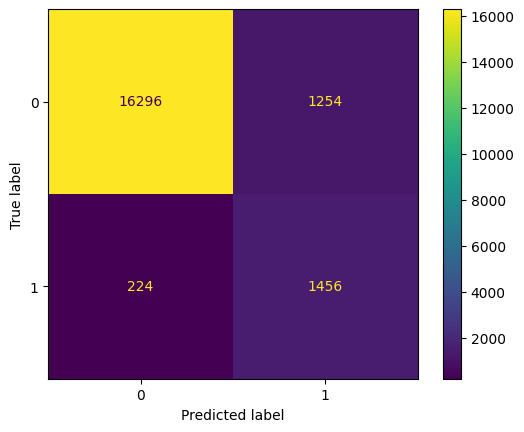

In [60]:
# Confusion matrix to display precision and recall. 
forest_clf_cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
p = ConfusionMatrixDisplay(confusion_matrix=forest_clf_cm, display_labels=forest_clf.classes_)
p.plot()
plt.show()

In [61]:
# Classification Report
forest_clf_cr = classification_report(y_true=y_test, y_pred=y_pred)
print(forest_clf_cr)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     17550
           1       0.54      0.87      0.66      1680

    accuracy                           0.92     19230
   macro avg       0.76      0.90      0.81     19230
weighted avg       0.95      0.92      0.93     19230



**The model with class weight=None, performs almost identically to the KNN classifier**

**The model with class weight='balanced', has by far the best recall; meaning fewer false negatives. HOWEVER: It comes at the cost of high precision, and the harmonic mean of precision and recall (f-1 score)** 

**Let's try a AdaBoost meta learning approach, selecting the number of weak learnings through the Elbow Method**

Text(0, 0.5, 'Recall Error')

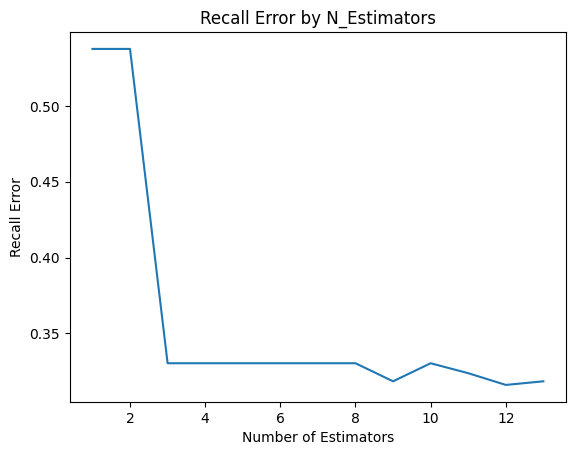

In [62]:
# Here we create n models, 1 for each number of columns. We determine the best model based on having the lowest false negative score
recall_error = []
for i in range(1, len(final_df.columns)):
    clf = AdaBoostClassifier(n_estimators=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    recall_error.append(1 - recall_score(y_true=y_test, y_pred=y_pred))
plt.plot(range(1, len(final_df.columns)), recall_error)
plt.title('Recall Error by N_Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Recall Error')

**We see the recall error drop immediately from 1 estimator to 3. Then more estimators only produce a slightly lower recall on the training data. To avoid introducing too much variance (overfitting), we will use n_estimaros = 3 to maintain a high level of bias**

In [63]:
# Classifier with the lowest recall error
ada_clf = AdaBoostClassifier(n_estimators=3, random_state=101)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

Text(0.5, 1.0, 'Importance by Feature')

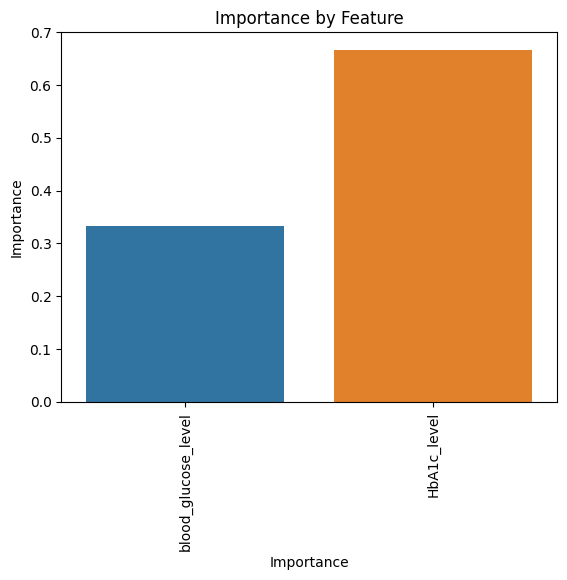

In [64]:
# Show the features with importance > 0
feature_imp = pd.DataFrame(index=X.columns, data=ada_clf.feature_importances_, columns=['Importance'])
feature_imp = feature_imp[feature_imp['Importance'] > 0.0001]
feature_imp = feature_imp.sort_values('Importance')
sns.barplot(x=feature_imp.index, y='Importance', data=feature_imp)
plt.xlabel('Feature')
plt.xlabel('Importance')
plt.xticks(rotation=90)
plt.title('Importance by Feature')

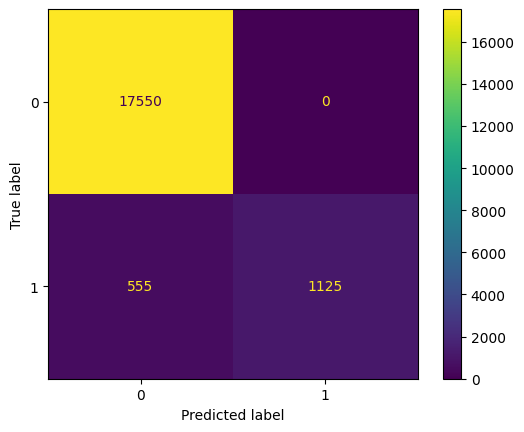

In [65]:
# Confusion matrix to display precision and recall.
ada_cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
p = ConfusionMatrixDisplay(confusion_matrix=ada_cm, display_labels=ada_clf.classes_)
p.plot()
plt.show()

In [66]:
# Classification Report
ada_cr = classification_report(y_true=y_test, y_pred=y_pred)
print(ada_cr)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17550
           1       1.00      0.67      0.80      1680

    accuracy                           0.97     19230
   macro avg       0.98      0.83      0.89     19230
weighted avg       0.97      0.97      0.97     19230



**The model performs almost identically to the KNN model, but is much more complex: We see again and again that HbA1c and Blood Glucose are the most important determiners.**

**Let's try a Cross-Validated GradientBoost**

In [67]:
# Search for optimal hyperparameters
base_clf = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [.05, .1, .15, .2],
    'max_depth': [3, 4, 5]
}
grid_clf = GridSearchCV(estimator=base_clf, param_grid=param_grid)
grid_clf.fit(X_train, y_train)
best_params = grid_clf.best_params_ 
best_params

{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 50}

In [68]:
# Model with the best parameters
gradient_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=.15, max_depth=3, random_state=101)
gradient_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

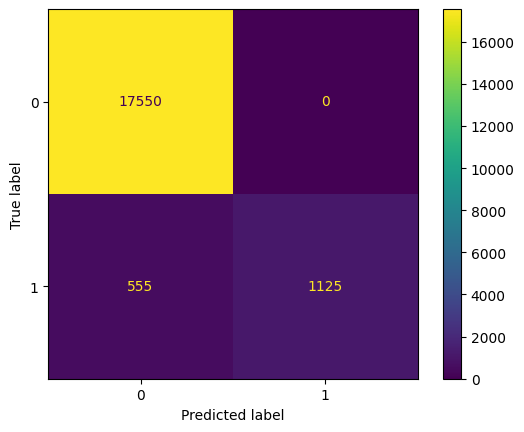

In [69]:
# Confusion matrix to display precision and recall. 
gradient_cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
p = ConfusionMatrixDisplay(confusion_matrix=gradient_cm, display_labels=forest_clf.classes_)
p.plot()
plt.show()

In [70]:
# Classification Report
gradient_cr = classification_report(y_true=y_test, y_pred=y_pred)
print(gradient_cr)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17550
           1       1.00      0.67      0.80      1680

    accuracy                           0.97     19230
   macro avg       0.98      0.83      0.89     19230
weighted avg       0.97      0.97      0.97     19230



**Another identical performer to KNN**

**Final Model: Cross Validated LogisticRegression utizing ElasticNet Regularization**

In [71]:
# Scale data for logistic regression
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [72]:
# Grid search best hyperparameters
model = LogisticRegression(penalty='elasticnet', solver='saga', multi_class='ovr', max_iter=100)
param_grid = {
    'l1_ratio': [.1, .3, 9, .99, .999, 1],
    'C': np.logspace(0, 10, 5) # SciKit Learn recommends logrithmic spacing!
}
grid_model = GridSearchCV(estimator=model, param_grid=param_grid)
grid_model.fit(X=scaled_X_train, y=y_train)
best_params = grid_model.best_params_
best_params

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklea

{'C': 1.0, 'l1_ratio': 0.1}

In [73]:
# Model w/ best hyperparameters and balanced class weight
model = LogisticRegression(l1_ratio=.1, C=1, class_weight='balanced', penalty='elasticnet', solver='saga', multi_class='ovr')
model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test)

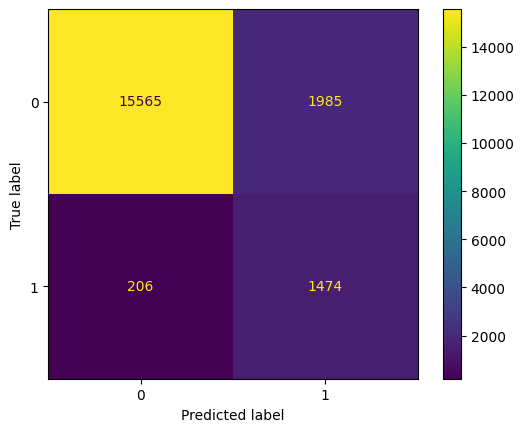

In [74]:
# Confusion matrix to display precision and recall. 
log_cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
p = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=model.classes_)
p.plot()
plt.show()

In [75]:
# Classification Report
log_cr = classification_report(y_true=y_test, y_pred=y_pred)
print(log_cr)

              precision    recall  f1-score   support

           0       0.99      0.89      0.93     17550
           1       0.43      0.88      0.57      1680

    accuracy                           0.89     19230
   macro avg       0.71      0.88      0.75     19230
weighted avg       0.94      0.89      0.90     19230



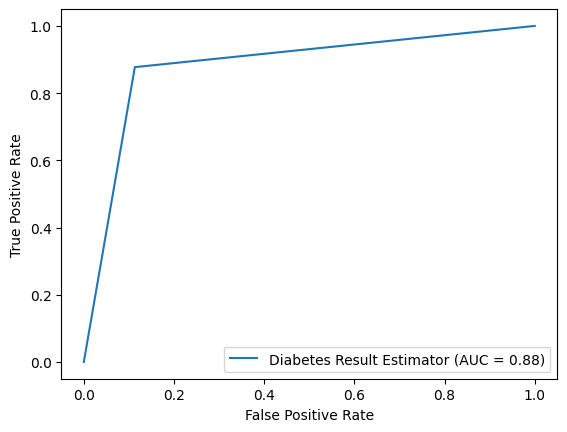

In [76]:
# Visualized ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
p = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Diabetes Result Estimator')
p.plot()

### Summary of Findings

Most models performed with a high level of accuracy, but low recall. This is likely the result of an imbalanced dataset, i.e. many more non-diabetic individuals than diabetic. 

Depending on context, the two models I would consider utilizing are the K Nearest Neighbors Classifier, and the Random Forest Ensemble with balanced weight.

The K Nearest Neighbors Classifier has an accuracy of 97% and is wonderfully simple. It only relies upon two features: blood glucose and HbA1c levels to predict diabetes. It has high bias, meaning it is not overfitted and would perform similarly on new blood glucose and HbA1c data.

Likely, the model I would recommend the most, is the Random Forest Meta Learning Model. If the goal of the data set, is to predict when an individual has diabetes, this model performs that task the best; it has the highest recall. It does come at the cost of significantly higher precision, however, meaning that the false positive rate is much higher. 

In practice, what the Random Forest Classifier would allow a physician to do is, view a patient's age, blood glucose and HbA1c levels. If those statistics fell below a certain percentage, it could be inferred from the model they are not at risk of diabetes. It they were predicted to be diabetic, further medical tests could be performed on the patient to determine whether or not they are in fact diabetic, or if the model falsely predicted them to be so (false positive). 